## John Conway's game of life implemented on python

Just a little bit of working around with the famous evolving model system designed by [John Conway](https://en.wikipedia.org/wiki/John_Horton_Conway) called [Game of Life](https://en.wikipedia.org/wiki/Conway%27s_Game_of_Life). Although the rules of the system is extremely simple, an astounishing complexity of "organisms" can be created. Surprisingly, since the initial publication of the system in the 1970s, mathematicias are still actively researching the emerging strucures and by this day over 8000 patterns have been identified from a dozens of established classes.

**The rules**:
1. The universe of the Game of Life is an infinite two-dimensional orthogonal grid of square cells, each of which is in one of two possible states, alive or dead. 
2. Every cell interacts with its eight neighbours, which are the cells that are horizontally, vertically, or diagonally adjacent.
3. Any live cell with fewer than two live neighbours dies, as if caused by under-population.
4. Any live cell with two or three live neighbours lives on to the next generation.
5. Any live cell with more than three live neighbours dies, as if by over-population.
6. Any dead cell with exactly three live neighbours becomes a live cell, as if by reproduction.

In this workbook, a game of life engine is implemented with 3 possible mechanism of pattern genergations:
1. Paterns can be randomly generated ("soup")
2. An established pattern can be downloaded from the cetral pattern [library](http://www.conwaylife.com/wiki/Category:Patterns).
3. A bitmap of a pattern can be read pixel by pixel to reconstruct the pattern.

In [1]:
import datetime
print datetime.datetime.now()

2016-05-15 00:15:34.285002


In [2]:
# The following packages are required for the calculation:
import numpy as np # The system is represented in an 2-dimensional array.
# import seaborn as sns; sns.set() # quick visualization of the actual state of the system.
# import cairosvg # Create bitmap image from an svg.
import imageio # Compile images into an animation.
import requests # Retrieve pattern from pattern database.
import scipy.misc # loaded pilutil from to create image.

# plot heatmap in the notebook.
%matplotlib inline 

//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


### Functions

Some of these functions are not used, as they were designed for a previous versions when the individual states of the system were plotted as svg files, converted to png and then saved as a frame of a gif or mp4.

In [3]:
def draw_svg(matrix):
    '''
    Based on the provided matrix, the function returns a formatted svg 
    image ready to be saved.
    '''
    # Get dimensions:
    (width, height) = matrix.shape

    # Draw svg image:
    svg = '<svg width="%s" height="%s" style="background-color: blue">\n' % (width, height)
    svg += '\t<rect x="-2" y="-2" width="%s" height="%s" style="fill:white;stroke:white;stroke-width:1" />\n' % (
        width * 2.5, height * 2.5)
    nonZero = np.nonzero(matrix)
    for index, x in enumerate(nonZero[0]):
        y =nonZero[1][index]
        svg += '\t<rect x="%s" y="%s" width="1" height="1" style="fill:rgb(0,0,0);stroke:rgb(0,0,0);stroke-width:1" />\n' % (
            x, y)
    svg += '</svg>'

    return svg

def get_dying(matrix):
    '''
    This function returns a list of coordinates of the dying 
    cells.
    '''
    nonZero = np.nonzero(matrix)
    dying = []
    for index, x in enumerate(nonZero[0]):
        # Find dying cells:
        y = nonZero[1][index]
        # Get all non-zero element.
        
        # Dying because of of overpopulation (More than 3 neighbour):
        if  get_neighbours(x,y,matrix) > 3: 
            dying.append((x,y))

        # Dying because of of under population (Less than two neighbour):
        if get_neighbours(x,y,matrix) < 2: 
            dying.append((x,y))

    # Returning the coordinates of dying cells:
    return dying

def get_neighbours(x,y,matrix):
    '''
    given the x and y coordnates of a matrix, this function
    returns the number of non-zero neighbours of given coordinate
    '''
    # print matrix[(x-1):(x+2), (y-1):(y+2)]
    if matrix[x,y] == 1: 
        return np.count_nonzero(matrix[(x-1):(x+2), (y-1):(y+2)]) - 1 
    else: 
        return np.count_nonzero(matrix[(x-1):(x+2), (y-1):(y+2)])

def get_born(matrix):
    '''
    this function returns with a list of tuples containing the 
    coordinates of newly borning cells.
    '''

    nonZero = np.nonzero(matrix)
    born = []
    for index, x in enumerate(nonZero[0]):
        # Find dying cells:
        y = nonZero[1][index]

        # Checking zero elements around the non-zero elements:
        for dx in [x - 1, x, x + 1]:
            for dy in [y - 1, y, y + 1]:
                if 0 <= dx < width and 0 <= dy < height:
                    if get_neighbours(dx, dy, matrix) == 3:
                        born.append((dx,dy))
    return born
    

# initialize random starting structures:
def initialize(matrix):
    '''
    This function takes a matrix as an input and at a 
    random position creates a 20 element big "patch of ones"
    
    This function is used to create a "soup".
    '''
    
    # get dimensions of the matrix:
    (w, h) = np.shape(matrix)
    
    # Get random coordinate:
    x = np.random.choice(w)
    y = np.random.choice(h)
    
    # Update matrix:
    matrix[x,y] = 1
    
    for i in range(20):
        # Updating x and y:
        (dx, dy) = np.random.choice([-1,0,1], 2)
        if 0 < x + dx < w and 0 < y + dy < h:
            i += 1
            x = x + dx
            y = y + dy
            matrix[x,y] = 1
    
    # Returning the modified matrix
    return matrix

def get_new_gen(matrix):
    '''
    This function calculates the newly born and dying cells
    Then removes the dying cells and add the newly forming ones.
    '''
    
    # Before any modification is done, we get the
    # list of cells:
    dying_cells = get_dying(matrix) 
    borning_cells = get_born(matrix)

    # Updating matrix:
    for dying in dying_cells:
        # print "dying: ", dying[0], dying[1]
        matrix[dying[0], dying[1]] = 0

    for born in borning_cells:
        # print "born: ", born[0], born[1]
        matrix[born[0], born[1]] = 1

    return matrix

def get_pattern_from_net(patternName, matrix):
    '''
    This function returns the coordinates of a pattern 
    given the URL pointing to the Life 1.06 version of the 
    pattern file.
    
    The pattern is added to the matrix.
    '''
    URL = 'http://www.conwaylife.com/patterns/%s_106.lif' % patternName
    r = requests.get(URL)
    x = []
    y = []
    
    if "DOCTYPE" in r.content:
        print "[Warning] The requested pattern (%s) was not found in the database." % patternName
        return matrix
    
    for line in r.content.split("\r\n"):
        line.strip()
        if "#" in line: continue # Skip header row
        coord = line.split(" ")
        if len(coord) > 1 :
            x.append(int(coord[0]))
            y.append(int(coord[1]))

    # Adding living cells to the word:
    xmin = abs(min(x))
    ymin = abs(min(y)) + 31
    for i, xi in enumerate(x):
        matrix[(xi + xmin), (y[i] + ymin)] = 1

    return matrix


def get_pattern_from_png(pngFile, matrix):
    '''
    This function reads the matrix of the pattern
    based on a image file submitted as a filename
    
    The pattern is positioned in the lower left corner of the
    matrix.
    
    Input: png file and the empty matrix
    Output: matrix with the pattern
    '''
    im = imageio.imread(pngFile)
    xlist = []
    ylist = []
    for x in range(im.shape[0]):
        for y in range(im.shape[1]):        
            try:
                if im[x,y][0] != 255 :
                    xlist.append(y)
                    ylist.append(x)
            except: 
                pass
            
    # Scaling x and y coordinates to make sure the pattern is 
    # located at the correct point.
    diff = matrix.shape[1] - (max(ylist) - min(ylist)) - 20
    for i, xi in enumerate(xlist):
        #print i, xi, ylist[i], ylist[i] + diff
        matrix[xi,ylist[i] + diff] = 1

    return matrix


def fill_image(matrix):
    '''
    This function takes a 2D matrix, and transforms into a 3D matrix, where the 3rd
    dimension is the RGB coordinates.
    
    White will be everywhere where the matrix had 0 and black where it had 1.
    '''
    
    # Initialize 3D array with only white cells:
    (w, h) = matrix.shape
    data = np.zeros((h,w,3), dtype=np.int16)
    data.fill(255)
    
    # Fill those pixels with black that are 1 in the matrix:
    nonzeroes = matrix.nonzero()
    for i, x in enumerate(nonzeroes[0]):
        data[nonzeroes[1][i],x] = [0,0,0]
        
    return data

### 1. Creating and evolving a soup:

1. Initialize a matrix.
2. Adding random patterns to the system.
3. Let evolve the system for 500 generations.
4. Report measured time.

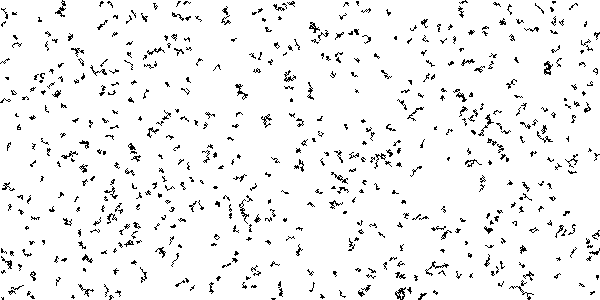

In [4]:
# Initialize matrix with a given size:
width = 600
height = 300
matrix = np.zeros((width, height), dtype=int) # It provides 180000 cells.

# Adding 700 random pattern to the system:
for i in range(700):
    matrix = initialize(matrix)

# Let's see the initial system:
data = fill_image(matrix)
img = scipy.misc.toimage(data)
img

In [101]:
t1 = datetime.datetime.now()
frame = 750
# Now evolve the system for 500 generations:
with imageio.get_writer('movie_2016.05.14_soup_750frame.mp4', mode='I') as writer:
    for i in range(frame):
        data = fill_image(matrix)
        writer.append_data(data)
        get_new_gen(matrix)

t2 = datetime.datetime.now()
print "Execution time: %s" % (t2 - t1)

Execution time: 0:05:44.804348


### 2. Creating and evolving a pattern dowloaded from the game of life website:

1. Initialize a matrix.
2. Download pattern from web (http://www.conwaylife.com/wiki/Category:Patterns)
3. Add pattern to the matrix.
3. Let evolve the system for 750 generations.
4. Report measured time.

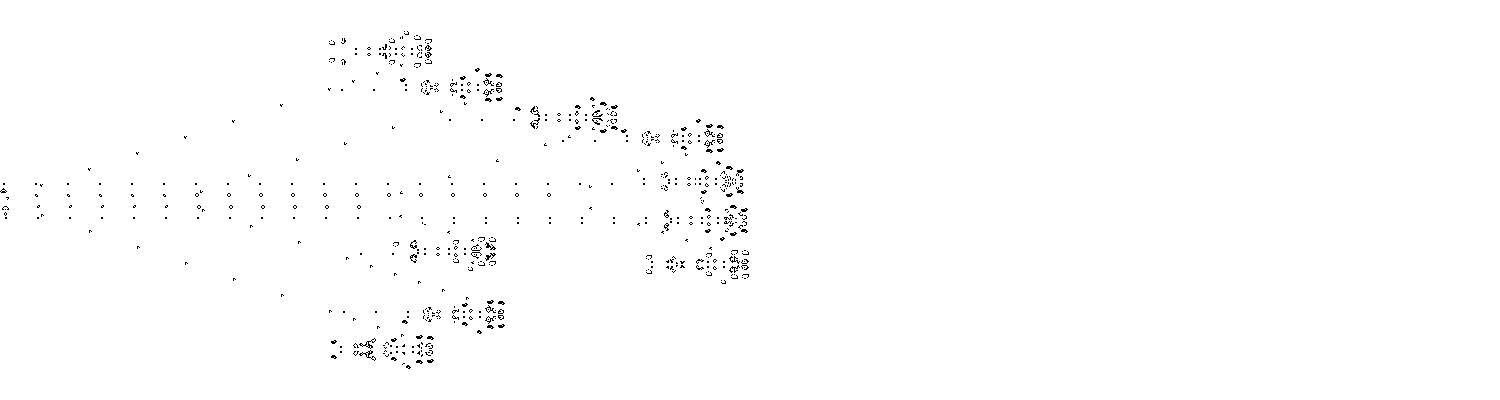

In [5]:
# Initialize matrix with a given size:
width = 1500
height = 400
matrix = np.zeros((width, height), dtype=int) # It provides 180000 cells.

# PAttern name:
pattern = "breeder1"

# pattern to the matrix:
matrix = get_pattern_from_net(pattern, matrix)

# Let's see the initial system:
data = fill_image(matrix)
img = scipy.misc.toimage(data)
img

In [116]:
t1 = datetime.datetime.now()
frame = 750
# Now evolve the system for 750 generations:
with imageio.get_writer('movie_2016.05.14_Breeder1_from_net_750frame.mp4', mode='I') as writer:
    for i in range(frame):
        data = fill_image(matrix)
        writer.append_data(data)
        get_new_gen(matrix)

t2 = datetime.datetime.now()
print "Execution time: %s" % (t2 - t1)

Execution time: 0:03:45.219866


### 3. Creating and evolving a pattern recovered from a bitmap:

This function was designed to recover the pattern that was shown in the [wikipedia](https://en.wikipedia.org/wiki/File:Conways_game_of_life_breeder_animation.gif) page of Game of Life. So I have downloaded the animation. Extracted the first frame of the gif file, then this single png file was the template for the reconstruction of the pattern.

1. Initialize a matrix.
2. Read image file, reconstruct pattern.
3. Add pattern to the matrix.
3. Let evolve the system for 750 generations.
4. Report measured time.

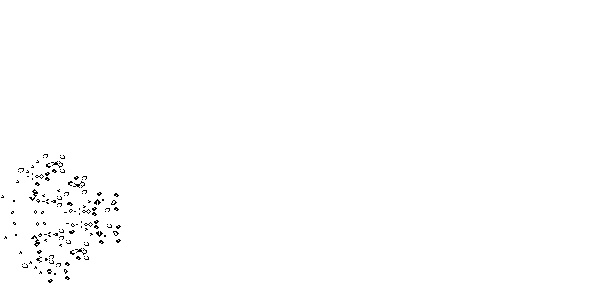

In [6]:
# Initialize matrix with a given size:
width = 600
height = 300
matrix = np.zeros((width, height), dtype=int)

# Adding the structure to the matrix:
matrix = get_pattern_from_png("Breeder_wiki.png", matrix)

# Create initial image:
data = fill_image(matrix)
img = scipy.misc.toimage(data)
img

In [119]:
t1 = datetime.datetime.now()
frame = 750
# Now evolve the system for 750 generations:
with imageio.get_writer('movie_2016.05.14_Breeder_from_image_750frame.mp4', mode='I') as writer:
    for i in range(frame):
        data = fill_image(matrix)
        writer.append_data(data)
        get_new_gen(matrix)

t2 = datetime.datetime.now()
print "Execution time: %s" % (t2 - t1)

Execution time: 0:01:17.498185


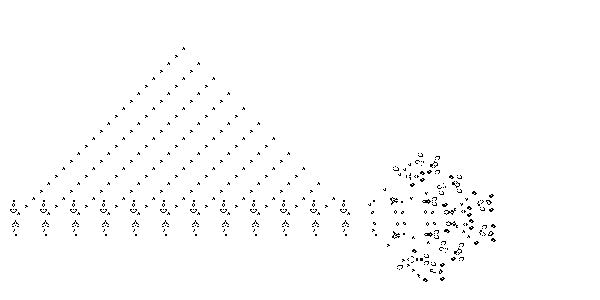

In [120]:
data = fill_image(matrix)
img = scipy.misc.toimage(data)
img